In [1]:
import utils_sleepasandroid as us
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# from collections import namedtuple
# import pendulum
import numpy as np
# import pathlib

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# First we'll parse one record from the Sleep as Android backup file

In [3]:
# Read in the Sleep as Android data and print some of the headers
SA_data = 'sample_data/SleepAsAndroid_data.csv'
sa_file_as_list = us.read_sleepasandroid_file(SA_data)
sa_file_as_list[0][0:15]

['Id',
 'Tz',
 'From',
 'To',
 'Sched',
 'Hours',
 'Rating',
 'Comment',
 'Framerate',
 'Snore',
 'Noise',
 'Cycles',
 'DeepSleep',
 'LenAdjust',
 'Geo']

In [4]:
# Parse the first record
ridx  = 0
split_record = us.split_sleepasandroid_record(sa_file_as_list, ridx)

# Print the awake records to get an idea of the data
split_record._fields

C:\ProgramData\Anaconda3\lib\site-packages\pendulum\pendulum.py:483: PendulumDeprecationWarning: The create() helper will no longer exist in version 2.0. Use datetime() instead.
  return cls.create(**actual_parts)


('start_datetime',
 'end_datetime',
 'record_start_ms',
 'record_end_ms',
 'light_sleep',
 'deep_sleep',
 'rem_sleep',
 'awake',
 'heart_rate',
 'hr_zone',
 'noise_events',
 'alarms',
 'timezone')

In [5]:
# what time zone is this record in?
split_record.timezone

'America/Edmonton'

## Now we'll take the parsed record and create records for each sleep stage

In [6]:
sleep_record, ls_record, ds_record, awake_record = us.parse_sleep_records(split_record)

In [7]:
sleep_record.stage

array(['LightSleep', 'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep',
       'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep', 'DeepSleep',
       'LightSleep', 'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep',
       'Awake', 'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep',
       'DeepSleep', 'LightSleep', 'Awake', 'DeepSleep', 'LightSleep'],
      dtype=object)

In [8]:
ls_record.cycle_start_time

[<Pendulum [2018-03-17T00:08:10.786000-06:00]>,
 <Pendulum [2018-03-17T00:38:10.786000-06:00]>,
 <Pendulum [2018-03-17T01:08:10.786000-06:00]>,
 <Pendulum [2018-03-17T02:03:10.786000-06:00]>,
 <Pendulum [2018-03-17T03:18:10.786000-06:00]>,
 <Pendulum [2018-03-17T03:33:10.786000-06:00]>,
 <Pendulum [2018-03-17T04:08:10.786000-06:00]>,
 <Pendulum [2018-03-17T04:33:10.786000-06:00]>,
 <Pendulum [2018-03-17T05:18:10.786000-06:00]>,
 <Pendulum [2018-03-17T05:33:10.786000-06:00]>,
 <Pendulum [2018-03-17T05:58:10.786000-06:00]>,
 <Pendulum [2018-03-17T06:43:10.786000-06:00]>]

In [9]:
awake_record.cycle_duration

[<Period [2018-03-17T04:40:16.260000-06:00 -> 2018-03-17T04:45:16.260000-06:00]>,
 <Period [2018-03-17T05:58:41.892000-06:00 -> 2018-03-17T06:08:41.892000-06:00]>]

In [10]:
sleep_record._fields

('ncycles',
 'cycle_start',
 'cycle_end',
 'duration_mins',
 'stage',
 'stage_code',
 'timezone')

In [11]:
sleep_record.duration_mins

array([ 5, 25, 15, 15, 15, 40, 60, 15,  5, 10, 25, 10, 15, 10, 10,  5, 35,
        5, 10, 15, 10, 15, 10, 30, 52])

# Now we will plot one of the sleep records

In [12]:
heartRateData = np.array(split_record.heart_rate)
heartRateData = np.array(heartRateData[:].T[2], dtype=float)
rHR_p5 = np.percentile(heartRateData, 5)
rHR = heartRateData.min()
print(rHR, rHR_p5)

61.40625 65.04676275


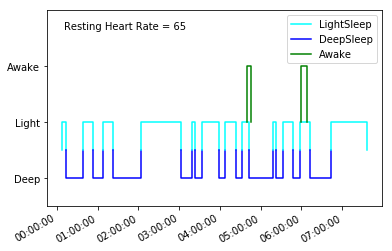

In [14]:
fig, ax = plt.subplots()
for idx in range(sleep_record.ncycles):
    start = sleep_record.cycle_start[idx]
    end = sleep_record.cycle_end[idx]
    x = [start, start, end, end]
    scode = sleep_record.stage_code[idx]
    
    if sleep_record.stage[idx] == 'LightSleep':
        y = [1.5, scode, scode, 1.5]
        c = 'cyan'
    elif sleep_record.stage[idx] == 'DeepSleep':
        y = [1.5, scode, scode, 1.5]
        c = 'blue'
    elif sleep_record.stage[idx] == 'Awake':
        y = [2, scode, scode, 2]
        c = 'green'
    ax.plot(x, y, color=c)
ax.plot([],[], c='cyan', label='LightSleep')
ax.plot([],[], c='blue', label='DeepSleep')
ax.plot([],[], c='green', label='Awake')
ax.legend(loc=1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
ax.set_ylim(0.5, 4)
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Deep', 'Light', 'Awake'])
ax.text(0.05, 0.9, 'Resting Heart Rate = {0}'.format(int(rHR_p5)), transform=ax.transAxes)
plt.savefig('examples/example_sleep_record.png', bbox_inches='tight')

# Lets iterate through the file now

In [15]:
fl_nLines = len(sa_file_as_list)
fl_nLines

175

In [16]:
idx = 0
RestingHR = []
RestingHRp5 = []
hr_date = np.array([], dtype='datetime64')
while idx < fl_nLines:
    if 'Id' in sa_file_as_list[idx]:
        split_record = us.split_sleepasandroid_record(sa_file_as_list, idx)
        if split_record:
            if split_record.heart_rate:
                heartRateData = np.array(split_record.heart_rate)
                heartRateData = np.array(heartRateData[:].T[2], dtype=float)
                RestingHRp5.append(int(np.percentile(heartRateData, 5)))
                RestingHR.append(int(heartRateData.min()))
                hr_date = np.append(hr_date, np.datetime64(split_record.start_datetime.to_date_string()))
                #hr_date.append(split_record.start_datetime.to_date_string())
    idx += 1

C:\ProgramData\Anaconda3\lib\site-packages\pendulum\pendulum.py:483: PendulumDeprecationWarning: The create() helper will no longer exist in version 2.0. Use datetime() instead.
  return cls.create(**actual_parts)
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:67: UserWarning: manual entry found, unable to parse sleep data
  warnings.warn('manual entry found, unable to parse '
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: unrecognized event: ['LOW_BATTERY', '1518789353255']
  warnings.warn("unrecognized event: {0}".format(event))
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: unrecognized event: ['TRACKING_PAUSED', '1516371135501']
  warnings.warn("unrecognized event: {0}".format(event))
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: unrecognized event: ['TRACKING_RESUMED', '1516371330484']
  warnings.warn("unrecognized event: {0}".format(event))
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: u

In [17]:
# What days did I collect heart rate data from?
hr_date

array(['2018-03-17', '2018-03-16', '2018-03-15', '2018-03-12',
       '2018-03-11', '2018-03-10', '2018-03-09', '2018-03-07',
       '2018-03-06', '2018-03-05', '2018-03-04', '2018-03-03',
       '2018-03-02', '2018-03-01', '2018-02-28', '2018-02-27',
       '2018-02-26', '2018-02-25', '2018-02-24', '2018-02-23',
       '2018-02-21', '2018-02-20', '2018-02-18', '2018-02-17',
       '2018-02-16', '2018-02-14', '2018-02-13', '2018-02-11',
       '2018-02-10', '2018-02-09', '2018-02-08', '2018-02-07',
       '2018-02-06', '2018-02-05', '2018-02-03', '2018-02-02',
       '2018-02-01', '2018-01-31', '2018-01-30', '2018-01-29',
       '2018-01-27', '2018-01-26', '2018-01-25', '2018-01-24',
       '2018-01-23', '2018-01-21', '2018-01-20', '2018-01-19',
       '2018-01-17', '2018-01-16', '2018-01-15', '2018-01-14',
       '2018-01-12', '2018-01-11', '2018-01-10', '2018-01-09',
       '2018-01-08', '2018-01-05', '2018-01-04', '2018-01-03',
       '2018-01-02', '2018-01-01', '2017-12-30', '2017-

## Plot the resting heart data 

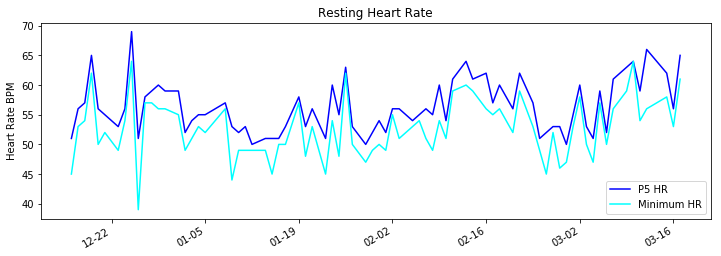

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot_date(hr_date, RestingHRp5, 'blue', label='P5 HR')
ax.plot_date(hr_date, RestingHR, 'cyan', label='Minimum HR')
ax.set_title('Resting Heart Rate')
ax.set_ylabel('Heart Rate BPM')
ax.legend(loc=4)
#ax.format_xdata = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.savefig('examples/example_resting_heartrate.png', bbox_inches='tight')